# Unit 5 - Financial Planning

In [2]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import datetime
import json
%matplotlib inline

In [3]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [6]:
# Fetch current BTC price
btc_fetch = requests.get(btc_url)
btc_json = btc_fetch.json()

# Fetch current ETH price
eth_fetch = requests.get(eth_url)
eth_json = eth_fetch.json()

# Compute current value of my crpto
my_btc_value = my_btc * btc_json['data']['1']['quotes']['CAD']['price']
my_eth_value = my_eth * eth_json['data']['1027']['quotes']['CAD']['price']

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value}")

The current value of your 1.2 BTC is $52266.0138
The current value of your 5.3 ETH is $15207.596975999999


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")



# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [9]:
# Format current date as ISO format
start_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-04-30", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_ticker = api.get_barset(tickers, timeframe, limit = 1000, start = start_date, end = end_date).df
df_ticker.index = df_ticker.index.date

# Preview DataFrame
df_ticker.head()

AGG                                            SPY            \
              open      high       low    close    volume    open      high   
2020-05-01  116.97  117.0998  116.6775  116.900  11778582  285.31  290.6572   
2020-05-04  116.89  117.0900  116.8700  116.975   6950122  280.74  283.9000   
2020-05-05  116.96  116.9700  116.8100  116.880   7315932  286.64  289.2500   
2020-05-06  116.44  116.7100  116.3000  116.450   9313368  288.04  288.4600   
2020-05-07  116.61  116.7600  116.4200  116.730   7338194  287.75  289.7800   

                                       
               low   close     volume  
2020-05-01  281.52  282.73  111321036  
2020-05-04  279.13  283.66   70199660  
2020-05-05  285.75  286.22   72232658  
2020-05-06  283.78  284.29   65371977  
2020-05-07  287.13  287.70   68883538

In [14]:
# Pick AGG and SPY close prices
# Taking the latest price based on the data captured from Alpaca
agg_close_price = df_ticker['AGG']['close'][-1]
spy_close_price = df_ticker['SPY']['close'][-1]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $114.5
Current SPY closing price: $417.3


In [15]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $20865.00
The current value of your 200 AGG shares is $22900.00


### Savings Health Analysis

In [18]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
shares = my_spy_value + my_agg_value
crypto = my_btc_value + my_eth_value

# Create savings DataFrame

df_savings = pd.DataFrame({'category':['crypto', 'shares'], 'amount':[crypto, shares]})
df_savings = df_savings.set_index('category')

# Display savings DataFrame
display(df_savings)
df_savings['amount'].sum()

,amount
category,
crypto,67473.610776
shares,43765.000000


111238.610776

<AxesSubplot:ylabel='amount'>

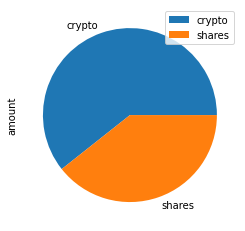

In [19]:
# Plot savings pie chart
df_savings.plot(kind = 'pie', y = 'amount')

In [20]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = df_savings['amount'].sum()

# Validate saving health
if savings > emergency_fund:
    print('Congratulations! You have enough money in your emergency fund.')
elif savings == emergency_fund:
    print('Congratulations! You have reached your financial goal')
else:
    print(f'You are still ${emergency_fund - savings} away from reaching the goal')

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [21]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [22]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = api.get_barset(tickers, timeframe, limit = 1000, start = start_date, end = end_date).df
df_stock_data.index = df_stock_data.index.date

# Display sample data
df_stock_data.head()

AGG                                          SPY          \
              open     high       low    close   volume    open    high   
2017-05-11  108.35  108.540  108.3435  108.515  1773499  239.35  239.57   
2017-05-12  108.81  108.940  108.7800  108.920  1136553  239.09  239.21   
2017-05-15  108.85  108.940  108.8200  108.890  1620264  239.47  240.44   
2017-05-16  108.88  109.101  108.8800  109.000  1394153  240.62  240.67   
2017-05-17  109.35  109.600  109.2800  109.560  2263851  238.10  238.64   

                                        
               low    close     volume  
2017-05-11  238.13  239.410   45435690  
2017-05-12  238.67  239.030   35283567  
2017-05-15  239.45  240.245   42230620  
2017-05-16  239.63  240.100   37206183  
2017-05-17  235.75  235.850  118613594

In [23]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
simulation =MCSimulation(
                            df_stock_data,
                            weights = [0.4,0.6],
                            num_simulation = 500,
                            num_trading_days = 252*30)

In [24]:
# Printing the simulation input data
simulation.portfolio_data.head()

AGG                                                       SPY  \
              open     high       low    close   volume daily_return    open   
2017-05-11  108.35  108.540  108.3435  108.515  1773499          NaN  239.35   
2017-05-12  108.81  108.940  108.7800  108.920  1136553     0.003732  239.09   
2017-05-15  108.85  108.940  108.8200  108.890  1620264    -0.000275  239.47   
2017-05-16  108.88  109.101  108.8800  109.000  1394153     0.001010  240.62   
2017-05-17  109.35  109.600  109.2800  109.560  2263851     0.005138  238.10   

                                                             
              high     low    close     volume daily_return  
2017-05-11  239.57  238.13  239.410   45435690          NaN  
2017-05-12  239.21  238.67  239.030   35283567    -0.001587  
2017-05-15  240.44  239.45  240.245   42230620     0.005083  
2017-05-16  240.67  239.63  240.100   37206183    -0.000604  
2017-05-17  238.64  235.75  235.850  118613594    -0.017701

In [25]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002204,0.992750,1.010646,1.006291,1.003488,0.979616,0.996928,1.003651,0.999930,1.007671,...,1.008028,1.009810,0.971536,0.995296,0.992027,0.998848,1.002358,1.006211,0.994525,1.000684
2,1.007313,0.993193,1.008560,1.007794,0.998976,0.983806,0.987348,0.997532,1.010679,0.978549,...,0.999250,1.010894,0.961202,0.998072,0.980453,1.002678,1.009455,1.002735,0.996467,0.999981
3,1.001181,0.989745,1.015251,1.002727,1.008924,0.985324,0.989106,0.994061,1.013561,0.979442,...,0.996867,1.007503,0.962038,0.998461,0.980305,1.020402,1.009961,1.004947,1.002058,0.999456
4,1.007290,0.997310,1.036299,1.009202,1.007998,0.976941,0.989113,1.000323,1.021020,0.980184,...,0.998930,0.997848,0.958783,1.000175,0.989363,1.018833,1.008038,0.994816,1.011817,1.005775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,25.269196,36.350205,20.675325,20.979758,23.755685,27.754663,20.479016,20.811101,11.695869,49.476773,...,19.185900,6.698440,19.899023,12.744332,9.491331,12.277609,16.572389,7.430662,6.714270,13.212568
7557,25.495445,36.334046,20.457843,20.952714,23.679241,27.774701,20.729382,20.696456,11.617543,49.654219,...,19.068282,6.596360,19.937669,12.736206,9.495791,12.317878,16.353842,7.462314,6.771867,13.137114
7558,25.875268,35.965068,20.765018,20.987751,23.325410,27.499706,20.755996,20.792635,11.630274,49.927699,...,18.975740,6.619165,20.119644,12.787455,9.534625,12.467203,16.247343,7.523624,6.799458,13.323907
7559,25.799746,35.689039,20.661696,21.051688,23.241163,27.433491,20.872375,20.567472,11.612463,49.911432,...,19.050641,6.621936,19.984511,12.847942,9.614405,12.525807,16.186934,7.493925,6.773847,13.312123


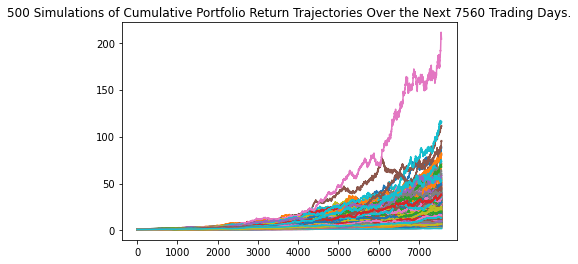

In [26]:
# Plot simulation outcomes
line_plot = simulation.plot_simulation()

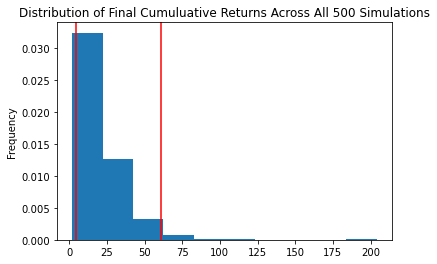

In [27]:
# Plot probability distribution and confidence intervals
dist_plot = simulation.plot_distribution()

### Retirement Analysis

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
saving_summary = simulation.summarize_cumulative_return()

# Print summary statistics
print(saving_summary)

count           500.000000
mean             21.960312
std              17.493092
min               1.998989
25%              11.411035
50%              17.552752
75%              27.997379
max             203.964845
95% CI Lower      4.376419
95% CI Upper     60.772507
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [29]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(saving_summary[8]*initial_investment,2)
ci_upper = round(saving_summary[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $87528.37 and $1215450.14


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [30]:
# Set initial investment
initial_investment_1 = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(saving_summary[8]*initial_investment_1,2)
ci_upper = round(saving_summary[9]*initial_investment_1,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_1} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $131292.56 and $1823175.21


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [31]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
simulation_1 =MCSimulation(
                            df_stock_data,
                            weights = [0.6,0.4],
                            num_simulation = 500,
                            num_trading_days = 252*5)

# Printing the simulation input data
simulation_1.portfolio_data.head()

AGG                                                       SPY  \
              open     high       low    close   volume daily_return    open   
2017-05-11  108.35  108.540  108.3435  108.515  1773499          NaN  239.35   
2017-05-12  108.81  108.940  108.7800  108.920  1136553     0.003732  239.09   
2017-05-15  108.85  108.940  108.8200  108.890  1620264    -0.000275  239.47   
2017-05-16  108.88  109.101  108.8800  109.000  1394153     0.001010  240.62   
2017-05-17  109.35  109.600  109.2800  109.560  2263851     0.005138  238.10   

                                                             
              high     low    close     volume daily_return  
2017-05-11  239.57  238.13  239.410   45435690          NaN  
2017-05-12  239.21  238.67  239.030   35283567    -0.001587  
2017-05-15  240.44  239.45  240.245   42230620     0.005083  
2017-05-16  240.67  239.63  240.100   37206183    -0.000604  
2017-05-17  238.64  235.75  235.850  118613594    -0.017701

In [32]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
simulation_1.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001769,0.990427,1.003348,0.998353,0.993691,0.997654,1.006864,1.006615,1.006838,0.998069,...,0.994451,1.005284,0.998104,1.000132,0.991793,0.999920,0.998602,1.007692,1.002190,0.995671
2,0.987912,1.000498,0.996316,0.987977,0.985670,1.000706,1.001803,0.998425,1.000397,0.999138,...,0.998321,1.002916,1.008760,0.990960,1.000923,1.003424,0.998658,1.004283,1.005309,0.996657
3,0.993019,1.008355,0.990743,0.988954,0.981842,1.007531,1.003362,1.000231,1.002277,0.993150,...,0.998501,1.003201,1.012356,0.988371,0.995168,1.002472,0.999621,1.002925,0.998738,0.994427
4,0.992410,1.012459,0.998005,0.995082,0.985499,1.010349,0.999272,1.001212,1.001105,0.990717,...,0.996500,0.995032,1.015901,0.983964,0.993969,1.006488,0.993730,0.999011,0.992876,1.003522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.175755,1.897262,1.362868,0.892822,1.543549,1.088387,1.702055,1.540964,1.102393,1.448705,...,1.381239,1.607441,1.645511,1.143898,1.324992,1.985707,1.406039,1.540022,1.304671,1.166219
1257,1.183525,1.884193,1.374684,0.899058,1.554115,1.084398,1.711509,1.554818,1.098909,1.443807,...,1.365412,1.591005,1.632292,1.142921,1.322337,1.990661,1.391365,1.532460,1.302430,1.163790
1258,1.191342,1.887987,1.371139,0.899480,1.531374,1.087919,1.714058,1.564883,1.101620,1.442153,...,1.354438,1.596411,1.642945,1.145207,1.325919,1.996785,1.389207,1.540830,1.289021,1.166739
1259,1.193407,1.894824,1.375492,0.902315,1.535901,1.087834,1.702766,1.560628,1.110360,1.446772,...,1.353537,1.586130,1.643885,1.139076,1.327239,1.988639,1.385932,1.543853,1.292259,1.165088


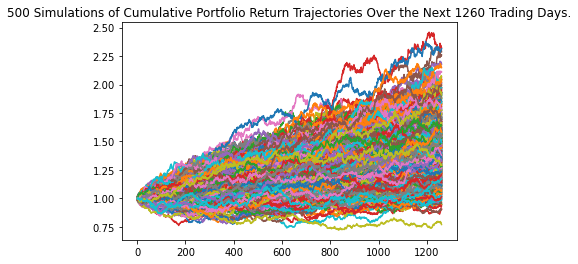

In [33]:
# Plot simulation outcomes
line_plot = simulation_1.plot_simulation()

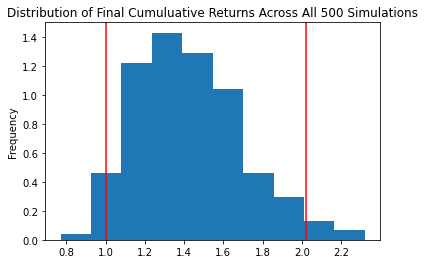

In [34]:
# Plot probability distribution and confidence intervals
dist_plot = simulation_1.plot_distribution()

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
saving_summary_5_years = simulation_1.summarize_cumulative_return()

# Print summary statistics
print(saving_summary_5_years)

count           500.000000
mean              1.427406
std               0.269163
min               0.770597
25%               1.229740
50%               1.397548
75%               1.591219
max               2.321643
95% CI Lower      0.999879
95% CI Upper      2.019408
Name: 1260, dtype: float64


In [36]:
# Set initial investment
initial_investment_2 = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(saving_summary_5_years[8]*initial_investment_2,2)
ci_upper_five = round(saving_summary_5_years[9]*initial_investment_2,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_2} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $59992.74 and $121164.49


### Ten Years Retirement Option

In [37]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
simulation_2 =MCSimulation(
                            df_stock_data,
                            weights = [0.6,0.4],
                            num_simulation = 500,
                            num_trading_days = 252*10)

# Printing the simulation input data
simulation_2.portfolio_data.head()

AGG                                                       SPY  \
              open     high       low    close   volume daily_return    open   
2017-05-11  108.35  108.540  108.3435  108.515  1773499          NaN  239.35   
2017-05-12  108.81  108.940  108.7800  108.920  1136553     0.003732  239.09   
2017-05-15  108.85  108.940  108.8200  108.890  1620264    -0.000275  239.47   
2017-05-16  108.88  109.101  108.8800  109.000  1394153     0.001010  240.62   
2017-05-17  109.35  109.600  109.2800  109.560  2263851     0.005138  238.10   

                                                             
              high     low    close     volume daily_return  
2017-05-11  239.57  238.13  239.410   45435690          NaN  
2017-05-12  239.21  238.67  239.030   35283567    -0.001587  
2017-05-15  240.44  239.45  240.245   42230620     0.005083  
2017-05-16  240.67  239.63  240.100   37206183    -0.000604  
2017-05-17  238.64  235.75  235.850  118613594    -0.017701

In [38]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
simulation_2.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002300,1.002535,0.989607,1.000355,1.007611,0.995637,0.990826,1.006395,1.007398,1.011495,...,0.996958,0.997806,0.999195,0.999082,1.002101,0.998642,0.993270,0.990604,1.003993,1.004051
2,1.002773,1.006950,0.987056,1.003892,1.005050,0.999787,1.005849,1.003506,1.007034,1.005903,...,1.002015,0.986418,1.000941,1.004705,1.002799,1.007335,0.995829,0.999935,1.002849,0.999583
3,0.994533,1.011122,0.974577,1.008485,1.006682,1.004001,1.003491,1.014260,1.018981,1.003866,...,1.004780,0.975123,1.001152,1.002990,0.998835,1.003944,0.997283,0.991859,1.000483,1.004712
4,0.991371,1.011527,0.965254,1.008050,0.998590,1.009980,1.009102,1.016229,1.025591,1.003484,...,1.004195,0.976309,1.005721,1.000952,0.998966,0.998452,0.988987,0.999378,1.006488,1.011403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.919879,2.370889,1.634040,1.786043,1.836173,1.798806,2.820833,2.314681,1.951252,1.908702,...,2.223935,1.952979,1.773234,2.795772,2.049756,3.041149,2.388326,1.334842,1.771122,1.754025
2517,1.913247,2.390723,1.644482,1.785795,1.849935,1.797115,2.831653,2.310082,1.941369,1.909453,...,2.245959,1.971539,1.780067,2.807506,2.064314,3.038751,2.406416,1.324842,1.773138,1.756481
2518,1.905399,2.402033,1.643459,1.786916,1.846731,1.814915,2.840609,2.301558,1.946319,1.908206,...,2.227398,1.995544,1.775373,2.830106,2.061284,3.071289,2.408884,1.334670,1.749645,1.751060
2519,1.917422,2.413447,1.640365,1.799064,1.852800,1.822508,2.834667,2.293383,1.942604,1.920322,...,2.238959,1.995680,1.777118,2.821885,2.055879,3.079299,2.430737,1.343292,1.757233,1.742843


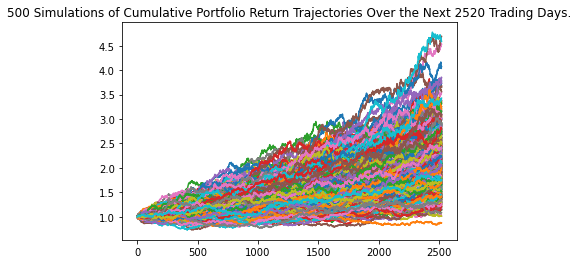

In [39]:
# Plot simulation outcomes
line_plot = simulation_2.plot_simulation()

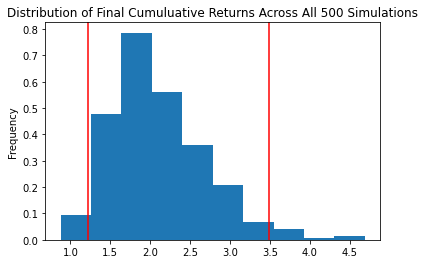

In [40]:
# Plot probability distribution and confidence intervals
dist_plot = simulation_2.plot_distribution()

In [41]:
# Fetch summary statistics from the Monte Carlo simulation results
saving_summary_10_years = simulation_2.summarize_cumulative_return()

# Print summary statistics
print(saving_summary_10_years)

count           500.000000
mean              2.097283
std               0.595314
min               0.875394
25%               1.685434
50%               1.995660
75%               2.429881
max               4.691170
95% CI Lower      1.217215
95% CI Upper      3.484665
Name: 2520, dtype: float64


In [42]:
# Set initial investment
initial_investment_3 = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(saving_summary_10_years[8]*initial_investment_3,2)
ci_upper_ten = round(saving_summary_10_years[9]*initial_investment_3,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_3} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $73032.88 and $209079.87
